In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading preprocessed dataset

In [ ]:
import pickle

In [ ]:
#Reading Files

X_train_filename = '/content/drive/MyDrive/IE434 Deep Dive 11 project/Deep Dive 3 (Milestone 2)/X_train.pkl'

with open(X_train_filename, 'rb') as file:
    X_train = pickle.load(file)

X_test_filename = '/content/drive/MyDrive/IE434 Deep Dive 11 project/Deep Dive 3 (Milestone 2)/X_test.pkl'

with open(X_test_filename, 'rb') as file:
    X_test = pickle.load(file)


y_train_filename = '/content/drive/MyDrive/IE434 Deep Dive 11 project/Deep Dive 3 (Milestone 2)/y_train.pkl'

with open(y_train_filename, 'rb') as file:
    y_train = pickle.load(file)


y_test_filename = '/content/drive/MyDrive/IE434 Deep Dive 11 project/Deep Dive 3 (Milestone 2)/y_test.pkl'

with open(y_test_filename, 'rb') as file:
    y_test = pickle.load(file)

## Training Dataset Preparation
- Pytorch Tensorization
- Split training data into training and validation part


In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import torch

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train.values)
y_test = label_encoder.fit_transform(y_test.values)

In [ ]:
y_test_df = pd.DataFrame(y_test)

In [ ]:
y_test_df.to_pickle('/content/drive/My Drive/IE434 Deep Dive 11 project/Deep Dive 4 (Milestone 3)/y_test_numerical.pkl')

In [ ]:
# pytorch tensorization
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# split training data into train and validation set
train_size = int(0.7 * len(X_train))
val_size = len(X_train) - train_size
train_X, train_y = X_train[:train_size], y_train[:train_size]
val_X, val_y = X_train[train_size:], y_train[train_size:]


print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  torch.Size([36576, 23])
y_train:  torch.Size([36576])
X_test:  torch.Size([9144, 23])
y_test:  torch.Size([9144])


## Build up Neural Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

### Gated Recurrent Unit

In [ ]:
class ImprovedGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout_rate=0.2):
        super(ImprovedGRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # GRU Layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=(dropout_rate if num_layers > 1 else 0))

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Fully connected Layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.gru(x, hidden)

        # Applying dropout to the output of the last GRU layer
        out = self.dropout(out)

        # Reshape output for the fully connected layer
        out = out.reshape(-1, self.hidden_size)

        # Get the final output
        out = self.fc(out)

        return out, hidden

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden


In [ ]:
def train_rnn_model(model, train_loader, val_loader, optimizer, criterion, epochs=20, clip_value=5):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.unsqueeze(1)
            batch_size = X_batch.size(0)
            hidden = model.init_hidden(batch_size)

            optimizer.zero_grad()
            output, hidden = model(X_batch, hidden)
            loss = criterion(output, y_batch)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            optimizer.step()
            train_loss += loss.item()

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.unsqueeze(1)
                batch_size = X_batch.size(0)
                hidden = model.init_hidden(batch_size)
                output, hidden = model(X_batch, hidden)
                loss = criterion(output, y_batch)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses


## Hyperparamter Search
- The below block is manually changed testing various hyper-parameters.
- The tested hyper-parameters are : Optimizers - Adam, SGD; Batch Size - 32,64,128; Learning Rate: 0.01,0.001; Number of Epochs

In [ ]:
# Adjusted hyperparameters
hidden_size = 50  # Increased hidden units
num_layers = 2    # Increased layers
dropout_rate = 0.2  # Dropout rate
input_size = X_train.shape[1]
output_size = 3

batch_size = 128

# Instantiate the improved model
# model_GRU = ImprovedGRUModel(input_size, hidden_size, output_size, num_layers, dropout_rate)
model_GRU = ImprovedGRUModel(input_size, hidden_size, output_size, num_layers, dropout_rate)


# Adjust the optimizer and learning rate if needed
optimizer = torch.optim.Adam(model_GRU.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(model_GRU.parameters(), lr=0.01)


# Use the same loss function
criterion = nn.CrossEntropyLoss()

# DataLoaders with shuffling for training set
train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_X, val_y), batch_size=batch_size, shuffle=False)


## Visualization of training Process

Epoch 1, Train Loss: 0.6147, Val Loss: 0.5831
Epoch 2, Train Loss: 0.6122, Val Loss: 0.5799
Epoch 3, Train Loss: 0.6181, Val Loss: 0.5949
Epoch 4, Train Loss: 0.6169, Val Loss: 0.5878
Epoch 5, Train Loss: 0.6160, Val Loss: 0.5849
Epoch 6, Train Loss: 0.6143, Val Loss: 0.5797
Epoch 7, Train Loss: 0.6201, Val Loss: 0.5836
Epoch 8, Train Loss: 0.6141, Val Loss: 0.5962
Epoch 9, Train Loss: 0.6159, Val Loss: 0.5850
Epoch 10, Train Loss: 0.6151, Val Loss: 0.5852
Epoch 11, Train Loss: 0.6131, Val Loss: 0.5758
Epoch 12, Train Loss: 0.6162, Val Loss: 0.5929
Epoch 13, Train Loss: 0.6168, Val Loss: 0.6557
Epoch 14, Train Loss: 0.6177, Val Loss: 0.5827
Epoch 15, Train Loss: 0.6214, Val Loss: 0.6012
Epoch 16, Train Loss: 0.6155, Val Loss: 0.5847
Epoch 17, Train Loss: 0.6138, Val Loss: 0.5703
Epoch 18, Train Loss: 0.6133, Val Loss: 0.5744
Epoch 19, Train Loss: 0.6084, Val Loss: 0.5915
Epoch 20, Train Loss: 0.6071, Val Loss: 0.5813
Epoch 21, Train Loss: 0.6079, Val Loss: 0.6199
Epoch 22, Train Loss: 

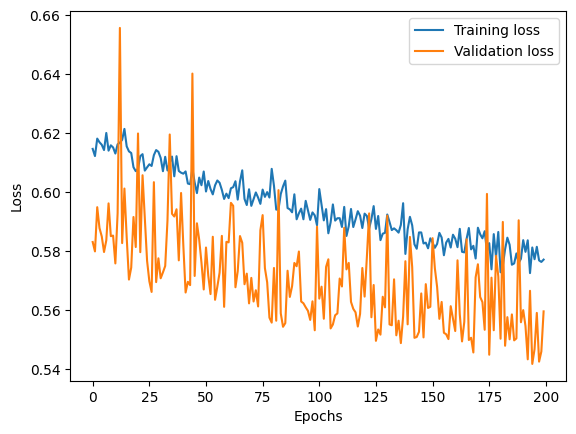

In [ ]:
# train neural network by launching backpropagation
train_losses, val_losses = train_rnn_model(model_GRU, train_loader, val_loader, optimizer, criterion, epochs=200)

# visualization of error curve
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Storing the model to calculate feature importance next Milestones

In [ ]:
model_GRU

ImprovedGRUModel(
  (gru): GRU(23, 50, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=50, out_features=3, bias=True)
)

In [ ]:
torch.save(model_GRU, '/content/drive/MyDrive/IE434 Deep Dive 11 project/Deep Dive 4 (Milestone 3)/model_GRU.pth')